# Dialogue's Data Science Code Challenge

## Reading the Data from Github

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
urlfile = "https://raw.githubusercontent.com/dialoguemd/Ken-Lam/master/data/chat_demand.csv?token=AD4EEZATQGCGABUY4CINSBTAOCBUE"
df = pd.read_csv(urlfile)

## Data Pre-Processing

In [3]:
df.head()

,date,eligible_users,chats
0,2017-01-01,10000,61.0
1,2017-01-02,10000,126.0
2,2017-01-03,10000,119.0
3,2017-01-04,10000,118.0
4,2017-01-05,10000,117.0


In [4]:
df.date = pd.to_datetime(df.date)
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['DoW'] = df['date'].dt.day_name()
df['Week'] = df['date'].dt.week

C:\Users\ken.lam\AppData\Local\Continuum\anaconda3\envs\py37_env\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [5]:
df

,date,eligible_users,chats,Year,Month,DoW,Week
0,2017-01-01,10000,61.0,2017,1,Sunday,52
1,2017-01-02,10000,126.0,2017,1,Monday,1
2,2017-01-03,10000,119.0,2017,1,Tuesday,1
3,2017-01-04,10000,118.0,2017,1,Wednesday,1
4,2017-01-05,10000,117.0,2017,1,Thursday,1
...,...,...,...,...,...,...,...
207,2017-07-27,42000,NaN,2017,7,Thursday,30
208,2017-07-28,42000,NaN,2017,7,Friday,30
209,2017-07-29,42000,NaN,2017,7,Saturday,30
210,2017-07-30,42000,NaN,2017,7,Sunday,30


<a id='eda'></a>
## Exploratory Data Analysis 

### Correlation

First, let's check the correlation between the number of eligible users and the chat volume with the Pearson correlation test. 

In [531]:
# Check the correlation between chat volume and number of eligible users
from scipy import stats
print('The Pearson Score is %s' %stats.pearsonr(plot_data[plot_data.index<'2017-07-01'].chats, plot_data[plot_data.index<'2017-07-01'].eligible_users)[0])

The Pearson Score is 0.9775360754776139


The number of eligible users and the chat volume are positively correlated and the Pearson’s correlation coefficient is 0.98; this suggests a high level of correlation between the two. 

### Trend

Next, I'll look whether there is any obvious trend in the chat volume and the number of eligible users over time. 

In [6]:
plot_data = df[['date','chats','eligible_users']]
plot_data = plot_data.set_index('date')

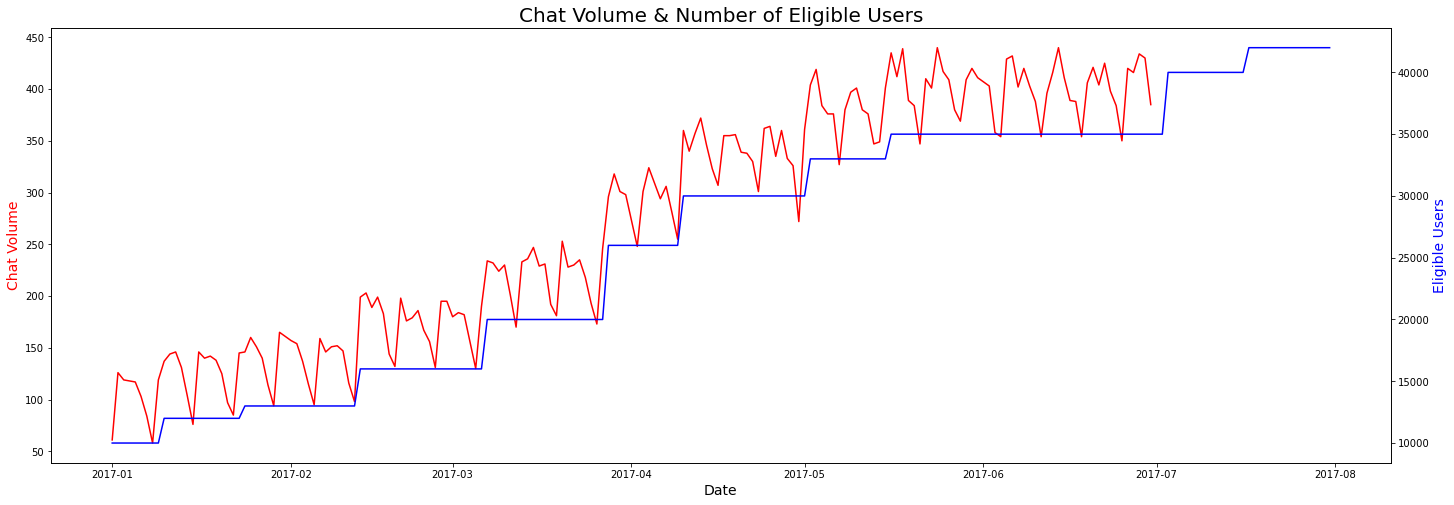

In [529]:
fix, ax = plt.subplots(figsize=(24,8))

#set x-label 
ax.set_xlabel("Date",fontsize=14)
#set plot chat volume
ax.plot(plot_data.chats, color="red")
ax.set_ylabel("Chat Volume",color="red",fontsize=14)
#set plot users in the same chart
ax2=ax.twinx()
ax2.plot(plot_data.eligible_users, color="blue")
ax2.set_ylabel("Eligible Users",color="blue",fontsize=14)
ax.set_title("Chat Volume & Number of Eligible Users", fontsize=20)
plt.show()

From the above plot, I can observe the following:
* A clear upward trend in both chat volume and number of eligible users
* There is a seasonality in the chat volume trend. 
* New set of eligible users seems to be always added to the pool of users on the same day(s) of the week. 
* Mid-May to beginning of July was the longest period without any increase in users. 
* The magnitude of seasonality in the chat volume does not seem to change in relation to time; this implies thatI should model it as a **additive seasonality**, rather than as a mutiplicative seasonality which has an increasing or decreasing amplitude and/or frequency over time  

The observed seasonality in chat volume looks like it could be a weekly pattern. I will confirm that by looking at the chat volume broken down by weeks. Notice that Janurary 1st 2017 falls on a Sunday, so Week no.1 of 2017 actually starts on Janurary 2nd; Janurary 1st 2017 will not be considered in the following chart for simplicity. 

Let me now take a look at whether there is a clear weekly pattern in the dataset or not. 

In [8]:
chat_data = df[df.Month!=7][['DoW','Week','chats']].iloc[1:]
day_dict = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
chat_data = chat_data.replace({"DoW": day_dict})

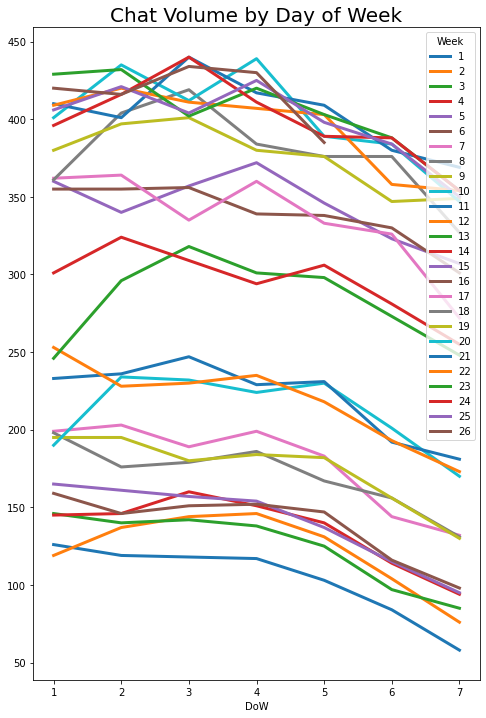

In [483]:
chat_pivot = pd.pivot_table(chat_data, index='DoW', columns = 'Week', values = 'chats')
chat_pivot.plot(figsize=(8,12), linewidth=3)
plt.title("Chat Volume by Day of Week", fontsize=20)
plt.show()

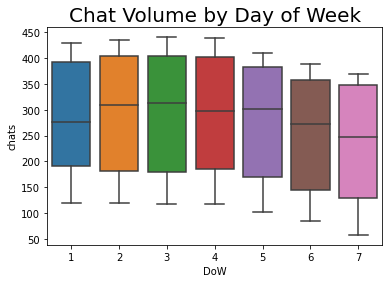

In [484]:
plt.title("Chat Volume by Day of Week", fontsize=20)
sns.boxplot(x="DoW", y="chats", data=chat_data)

As expected, from the above plots, I can see that the chat volume decreases over the course of the week, with Wednesday typically being the busiest day for most of the weeks. 

### New Users 

As mentioned earlier under the trends' observations, new batch of users are seemingly always introduced to the pool of users  on the same day(s) of week. Let me find out on which day(s) the increase happened in the past. 

Text(0.5, 1.0, 'New Users Introduction')

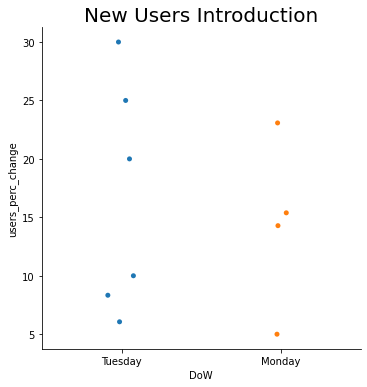

In [485]:
#Compute the percentage change of users 
df['users_perc_change'] = df.eligible_users.pct_change() * 100
df['users_perc_change'] = df['users_perc_change'].fillna(0)

#Identify the days where percentage change of users is greater than zero
user_data = df[df['users_perc_change']>0]
sns.catplot(x="DoW", y="users_perc_change", data=user_data)
plt.title("New Users Introduction", fontsize=20)

In [13]:
user_data['users_perc_change'].describe()

count    10.000000
mean     15.714119
std       8.564477
min       5.000000
25%       8.750000
50%      14.835165
75%      22.307692
max      30.000000
Name: users_perc_change, dtype: float64

From the categorical scatterplots above , I can see that the introduction of new users usually happens on **Tuesday and Monday**, with an **average increase of 15%**. 

### New Users' Impact on Daily Chat Volume

I want to get a general sense of the impact that new groups of users have on the average daily chats volume. 

In [14]:
#Compute the average daily volume, grouping by number of eligible users 
chat_increase_df = df[['eligible_users','chats']].groupby(['eligible_users']).mean()
chat_increase_df['mean_daily_chats_perc_change'] = chat_increase_df.chats.pct_change() * 100
chat_increase_df['mean_daily_chats_perc_change'] = chat_increase_df['mean_daily_chats_perc_change'].fillna(0)

In [15]:
chat_increase_df[chat_increase_df['mean_daily_chats_perc_change']>0]['mean_daily_chats_perc_change'].describe()

count     8.000000
mean     19.255753
std       9.684338
min       5.831991
25%      11.127838
50%      20.557742
75%      25.865159
max      33.122250
Name: mean_daily_chats_perc_change, dtype: float64

While the average increase of new users were previously found to be 15%, the **average increase in daily volume is 19%** after a new batch of users were introduced to the pool. 

## Forecasting

### Call Volume

There are multiple variables to be considered to optimally predict the chat volume (i.e. *weekly pattern* and *number of eligible users*).  

A series like this would fall under the category of multivariate time series. For that reason, I will use **Facebook's open sourced Prophet module**, belonging to the Generalized Additive Model (GAM) family of algorithms, to forecast the number of chats for each day of the month of July.

#### Fitting the Model

I will fit the Prophet model on **Janurary to April** data and reserve the remaining data as an evaluation set (approx 35%).  

In [643]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

#Define the Prophet model; as mentioned earlier, I will use the additive model for its seasonality. 
model = Prophet(seasonality_mode='additive',
            growth='linear',
            weekly_seasonality=True,
            yearly_seasonality=False,
            changepoint_prior_scale = 0.01,
            )
model.add_regressor('eligible_users', prior_scale=0.045, mode='additive')

df_train = df[['date','eligible_users','chats']]
df_train.rename(columns={'date':'ds','chats': 'y'}, inplace=True)

#Split the dataset into training set and test set
X_train = df_train.loc[df_train["ds"]<"2017-05-01"]
X_test  = df_train

model.fit(X_train)
forecast = model.predict(X_test.drop(columns="y"))
forecast['yhat'] = np.ceil(forecast['yhat'])

C:\Users\ken.lam\AppData\Local\Continuum\anaconda3\envs\py37_env\lib\site-packages\pandas\core\frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Results

The following plot shows the original data (black dots) used for the model, the evaluation set (red line), the model (blue line), and the error of the forecast (shaded blue area):

Text(0.5, 1.0, 'Prophet Model - Chat Volume Prediction')

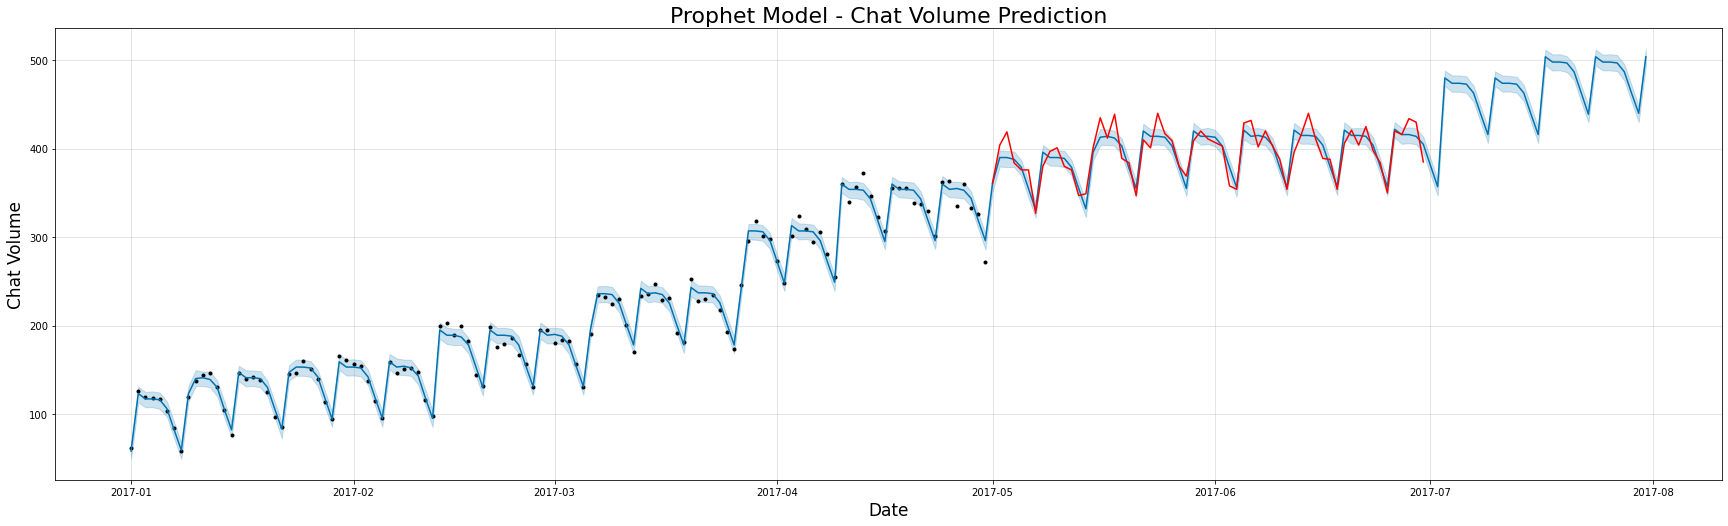

In [644]:
fix, ax = plt.subplots(figsize=(24,7))
model.plot(forecast, ax=ax);
ax.plot(plot_data[plot_data.index >='2017-05-01'].chats, color="red")
ax.set_xlabel("Date",fontsize=17)
ax.set_ylabel("Chat Volume", fontsize=17)
ax.set_title("Prophet Model - Chat Volume Prediction", fontsize=22)

Let's also take a look at the components of the model. This component plot is an important plot as it shows the components of my model including the trend and seasonality:

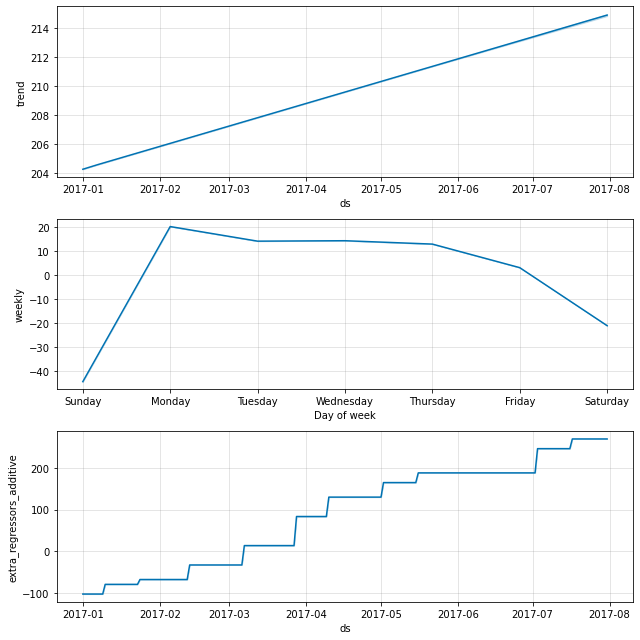

In [645]:
model.plot_components(forecast);

#### Evaluation

Let's now take a look at how well the model fits the evaluation set. 

In [646]:
eval_df = df_train.loc[(df_train["ds"]>="2017-05-01")&(df_train["ds"]<"2017-07-01")].copy()
eval_df['y_pred'] =forecast.loc[(forecast["ds"]>="2017-05-01")&(forecast["ds"]<"2017-07-01")].yhat 

In [647]:
eval_df.head()

,ds,eligible_users,y,y_pred
120,2017-05-01,30000,361.0,361.0
121,2017-05-02,33000,404.0,390.0
122,2017-05-03,33000,419.0,390.0
123,2017-05-04,33000,384.0,388.0
124,2017-05-05,33000,376.0,379.0


##### R-Squared Score

In [648]:
from sklearn.metrics import r2_score
print('The R-Squared Score is %s'  %r2_score(combined_df.y, combined_df.y_pred))

The R-Squared Score is 0.7822825796834385


An R-Squared of 78.2% reveals that 78.2% of the data fit the model, which is an acceptable level in general. 

##### Mean Absolute Error

In [660]:
from sklearn.metrics import mean_absolute_error

print('The MAE is %s'  %mean_absolute_error(combined_df.y, combined_df.y_pred))

The MAE is 9.915933212526353


The absolute error is the absolute value of the difference between the forecasted value and the actual value. MAE tells us how big of an error we can expect from the forecast on average. MAE=9.91 implies that, on average, the forecast's distance from the true value is approximately 10 chats, which is relatively insignificant when compared to the daily volume. 

##### Mean Absolute Percentage Error

In [662]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('The MAPE is %s'  %mean_absolute_percentage_error(combined_df.y, combined_df.y_pred))

The MAPE is 2.4740295844733153


The Mean Absolute Percent Error (MAPE) measures the error as a percentage of the actual value. A MAPE of 2.47% is very low, which means that my Prophet model is fairly accurate. 

### Staffing Condition

To predict the number of nurses needed per day in July, I will use **Erlang C** model. Erlang C is a call center queuing model that calculates call center staffing requirements for inbound calls; the formula is flexible enough to model modern real-time channels like chat, SMS, and social media in addition to phone calls. 

At its core, Erlang C estimates the required staffing for a given target response time and expected amount of contact volume.I have used this model extensively at Bell Canada to predict staffing condition in customer response centers.  


Since I don't have all the necessary variables for Erlang C formula, I will make the following assumptions:
* An **average handling time of 5 mins**; this is how long each nurse takes on average to process 1 chat. 
* A **target service level of 80%**;  also known as aservice-level agreement (SLA), it defines the level of service expected by a customer from a supplier.
* An **average waiting time of 20 secs**; this is how long an user will wait in the queue before assigning a nurse. 

Also, I'll consider that the following Erlang C assumptions are satisfied:
* Customers enter the queue randomly (Poisson distribution of arrivals)
* Service time distribution is exponential
* Negligible level of abandonments
* FIFO principle
* Customers are directed to the first available personnel
* Chat volumes do not vary dramatically

Note: The *80-20 rule* (i.e. 80% of the calls/chats being answered within 20 seconds.) is a common industry standard used in call centers.

In [650]:
import math 

def ErlangC(A, N):
    if (N-A<=0): 
        return 1 
    L = (A**N / math.factorial(N)) * (N / (N - A))
    sum_ = 0
    for i in range(N):
        sum_ += (A**i) / math.factorial(i)
    return (L / (sum_ + L))

def staffing(row, AHT=5, SLA=80, T=20):
    #AHT: average handling time (min)
    #SLA: service level agreement (aka target service level); industry standard is 80%
    #T: average waiting time in queue (sec)
    
    #Total chat durations
    A = AHT*row['yhat']/60
    
    #Calculate the service level at each increment of personnel
    for staff in range(1000):
        P = ErlangC(A, staff)
        sl = (1 - (P * math.exp(-((staff - A) * (T / (AHT*60)))))) * 100
        
    #If service level meets the Service Level Agreement (industry standard is 80%), return the number of personnel    
        if sl >= SLA: 
            return np.ceil(staff)

Predict the number of nurses needed per day:

In [651]:
forecast['nurses'] = forecast.apply(lambda row : staffing(row, AHT=5), axis = 1)
forecast['DoW'] = forecast['ds'].dt.day_name()
forecast.rename(columns={'ds':'date'}, inplace=True)

<a id='staffing'></a>
#### Results: No. of Nurses for each day of July

date,2017-07-01,2017-07-02,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,2017-07-12,2017-07-13,2017-07-14,2017-07-15,2017-07-16,2017-07-17,2017-07-18,2017-07-19,2017-07-20,2017-07-21,2017-07-22,2017-07-23,2017-07-24,2017-07-25,2017-07-26,2017-07-27,2017-07-28,2017-07-29,2017-07-30,2017-07-31
nurses,37.0,35.0,46.0,46.0,46.0,46.0,45.0,43.0,41.0,46.0,46.0,46.0,46.0,45.0,43.0,41.0,48.0,48.0,48.0,48.0,47.0,45.0,43.0,48.0,48.0,48.0,48.0,47.0,45.0,43.0,48.0


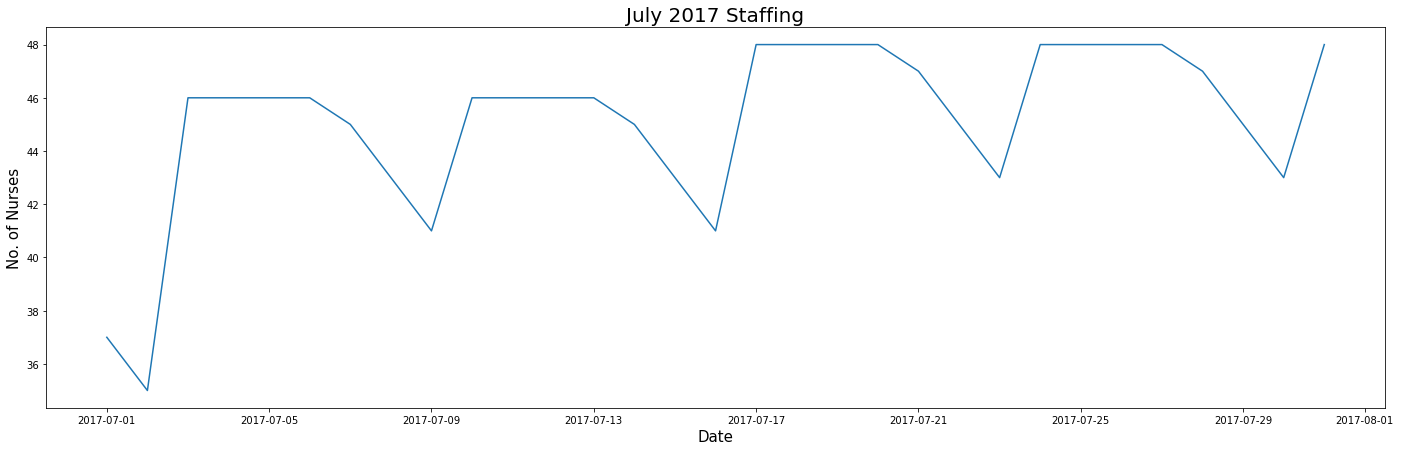

In [652]:
fix, ax = plt.subplots(figsize=(24,7))
sns.lineplot(data=forecast.set_index('date')['nurses'].tail(31))
plt.title('July 2017 Staffing', fontsize=20)
# Set x-axis label
plt.xlabel('Date', fontsize=15)
# Set y-axis label
plt.ylabel('No. of Nurses', fontsize=15)

#Display the data table
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
forecast.set_index('date')[['nurses']].tail(31).transpose()

The above chart shows the number of nurses needed for each day of July 2017. 

#### Results: Average Number of Nurses per Day

In [653]:
forecast[['date','yhat','nurses']].tail(31).describe()

,yhat,nurses
count,31.000000,31.000000
mean,466.225806,45.161290
std,36.046923,3.205171
min,357.000000,35.000000
25%,451.500000,44.000000
50%,474.000000,46.000000
75%,497.000000,48.000000
max,504.000000,48.000000


Based on the Erlang C formula, in order to maintain a service level of 80-20 (i.e. 80% of the chats being answered within 20 seconds), **a team of 45 nurses** is needed on average per day.

#### Results: Average Number of Nurses by Day of Week

           nurses
DoW              
Friday       46.0
Monday       48.0
Saturday     43.0
Sunday       41.0
Thursday     47.0
Tuesday      47.0
Wednesday    47.0


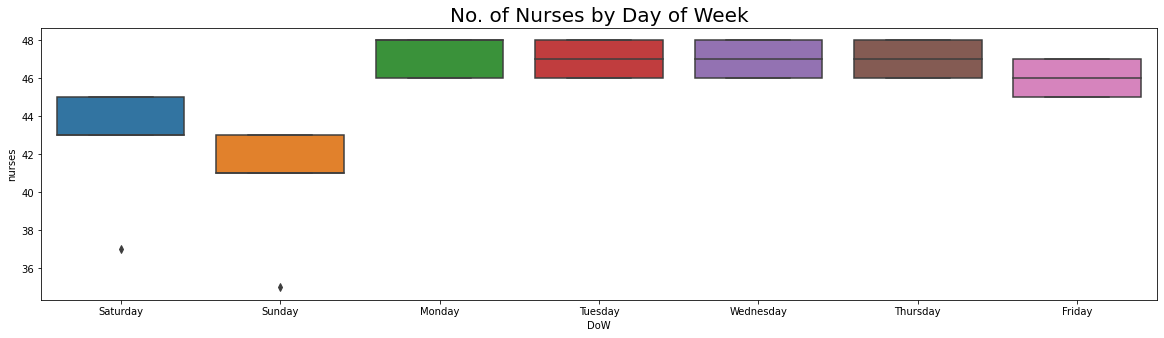

In [654]:
plt.subplots(figsize=(20,5))
plt.title("No. of Nurses by Day of Week", fontsize=20)
sns.boxplot(x="DoW", y="nurses", data=forecast[['DoW','nurses']].tail(31))
print(np.ceil(forecast[['DoW','nurses']].tail(31).groupby(['DoW']).mean()))

The above chart shows the number of nurses needed on average for each day of week, ranging from 41 to 48 nurses. 

## Exporting the Results

In [658]:
final_df = df[df.date>='2017-07-01'][['date','eligible_users']]
final_df['chats'] = np.ceil(forecast['yhat'].tail(31))
final_df['no_of_nurses'] = forecast['nurses'].tail(31)
final_df.to_csv('predictions.csv', index=False)

## Conclusion & Summary

<span style="color:blue">**1. Include an exploratory data analysis and report any finding on the dataset.**</span>

The following are all the findings & observations on the dataset:
* The number of eligible users and the chat volume are positively correlated and the Pearson’s correlation coefficient is 0.98; this suggests a high level of correlation between the two.
* A clear upward trend exists in both chat volume and number of eligible users.
* There is a seasonality in the chat volume. 
* New set of eligible users are typically added on Monday or Tuesday. 
* Mid-May to beginning of July was the longest period without any increase in users. 
* The magnitude of seasonality in the chat volume does not change in relation to time; it is therefore an **additive seasonality**.
* The average increase of new eligible users is 15% and its impact on the chat volume is approximately 19% of increase. 
* The chat volume decreases over the course of the week, with Wednesday typically being the busiest day for most of the weeks.


See [Exploratory Data Analysis section](#eda) for details.

<span style="color:blue">**2. Provide a recommendation on the number of nurses needed per day in July, please list the assumptions made to go from number of chats to number of nurses.**</span>

The following assumption were made to calculate the number of nurses needed:
* Dialogue's team of nurses operates in a similar responsive system as an inbound call centers (i.e. customers are placed in a virtual queue where they wait to interact with an agent)
* An **average handling time of 5 mins**; this is how long each nurse takes on average to process 1 chat. 
* A **servie level of 80-20** (i.e. 80% of the chats being answered within 20 seconds) 
* Customers enter the queue randomly (Poisson distribution of arrivals)
* Service time distribution is exponential
* Negligible level of abandonments
* FIFO principle
* Customers are directed to the first available personnel
* Chat volumes do not vary dramatically

With the above assumptions met, I can then use the **Erlang C queueing model** to predict the number of nurses for each day of July for a given number of chats. 

The result shows that **a team of 48 nurses** is needed to fully cover the month of July. For a detailed breakdown of how many nurses are needed for each day of July, please refer to [Results: No. of Nurses for each day of July](#staffing).



<span style="color:blue">**3. How would you evaluate the accuracy of your model?**</span>

To evaluate the accuracy of this chat forecasting model, I can backtest the Prophet model using existing historical data (i.e. July 2017 chat volume). I will use the Mean Absolute Percent Error (MAPE) to measure the error as a percentage of the actual value. 

Using the May-June 2017 data as an evaluation set, this is the performance of my model:
* R-Squared Score = 0.7822825796834385
* Mean Absolute Error = 9.915933212526353 
* Mean Absolute Percentage Error = 2.4740295844733153


<span style="color:blue">**4. If the team starts using this model to staff the clinic, how would you evaluate the impact of this change on Dialogue's operations?**</span>

To evaluate the impact of this model, I first need to measure the historical and current service level. If that's not something currently being measured at Dialogue, then this will be an important KPI to start tracking. 

Once service level data becomes available, I can then measure the percentage change in service level after the implementaton of this model. 

<span style="color:blue">**5. What are the next steps to improve the model’s accuracy and its impact on costs and quality of service?**</span>

To improve the chat forecasting model, I will need to gather additional historical data to better model the yearly and holidays seasonality. I will also compare the performance with other methods such as Vector Autoregression (VAR), RNN-LSTM, etc.     

The current staffing condition were calculated using an estimated average handling time of 5 mins. Therefore, to improve the accuracy of the staffing model, I need to assess what the actual average handling time is, which can potentially affect the staffing prediction of Erlang C. 

While it's a good starting point to staff the clinic based on the daily volume, it might also be a good idea to take hurly intervals into consideration, for a more reliable prediction. As the chat volume grows, Dialogue should also consider other Work Force Management principles (e.g. shrinkage, forecast down to 15 mins intervals, etc.)